In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from datetime import datetime, date

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
user_info = pd.read_csv('../data/data_format1/user_info_format1.csv')
user_log = pd.read_csv('../data/data_format1/user_log_format1.csv')

user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [3]:
train_data = pd.read_csv('../data/data_format1/train_format1.csv')
test_data = pd.read_csv('../data/data_format1/test_format1.csv')

**观察下是数据**

In [36]:
user_info['user_id'].unique().shape

(424170,)

In [40]:
#缺省性别的用户
user_info[user_info['gender'].isna() | (user_info['gender'] == 2)].count()

user_id      16862
age_range    14664
gender       10426
dtype: int64

In [44]:
#缺省年龄的用户
user_info[user_info['age_range'].isna() | (user_info['age_range'] == 0)].count()

user_id      95131
age_range    92914
gender       90664
dtype: int64

In [46]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
user_id        int64
item_id        int64
cat_id         int64
seller_id      int64
brand_id       float64
time_stamp     int64
action_type    int64
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


In [49]:
#用户行为覆盖所有的用户id
user_log['user_id'].unique().shape

(424170,)

In [51]:
user_log['seller_id'].unique().shape

(4995,)

In [12]:
train_data['merchant_id'].unique().shape

(1993,)

In [57]:
#训练集seller_id也是都在用户相关的seller中
len(list(set(train_data['merchant_id'].unique()).intersection(set(user_log['seller_id'].unique()))))

1993

**处理下缺失值**  
暂时不知怎么处理,年龄缺失挺多的,不知道怎么填充,暂时把性别处理一下

In [4]:
user_info[user_info['age_range'].isna() | (user_info['age_range'] == 0)].count()

#填为0
user_info['gender'].fillna(2, inplace=True)
user_info['age_range'].fillna(0, inplace=True)

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
user_id        260864 non-null int64
merchant_id    260864 non-null int64
label          260864 non-null int64
dtypes: int64(3)
memory usage: 6.0 MB


**观察和统计数据**

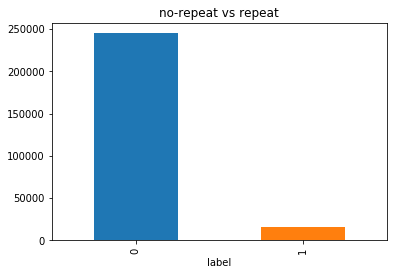

In [5]:
label_gp = train_data.groupby('label')['user_id'].count()
label_gp.plot(kind='bar',title='no-repeat vs repeat')

重复购买和不购买的,非常不均衡噢

In [8]:
train_data.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [14]:
user_log.rename(columns={'seller_id':'merchant_id'}, inplace = True)
buyer = pd.merge(train_data, user_log, how='left', on=['user_id', 'merchant_id'])
buyer.head()

,user_id,merchant_id,label,item_id,cat_id,brand_id,time_stamp,action_type
0,34176,3906,0,757713,821,6268.0,1110,0
1,34176,3906,0,757713,821,6268.0,1110,0
2,34176,3906,0,757713,821,6268.0,1110,0
3,34176,3906,0,718096,1142,6268.0,1031,3
4,34176,3906,0,757713,821,6268.0,1031,3


In [16]:
buyer.groupby(['label','user_id','merchant_id','item_id']).action_type.value_counts()

label  user_id  merchant_id  item_id  action_type
0      4        1186         745166   0              4
                                      2              1
       6        1356         559647   0              2
                                      2              1
                                      3              1
                4249         348105   0              4
                                      2              1
                                      3              1
                             963689   0              1
       7        1162         130621   2              1
                             167722   2              1
                             838713   2              1
                             865925   2              1
       8        4966         241738   0              4
                                      2              1
                                      3              1
       9        2721         74916    0              1
               

**合并训练集和测试集,方便抽取特征**

In [131]:
test_data['source'] = 'test'
train_data['source'] = 'train'

commit_data = test_data.drop(['prob'], axis=1)

data_combine = pd.concat([train_data, commit_data], sort=True)

data_combine = pd.merge(data_combine, user_info, how='left', on=['user_id'])
data_combine.head()

,label,merchant_id,source,user_id,age_range,gender
0,0.0,3906,train,34176,6.0,0.0
1,0.0,121,train,34176,6.0,0.0
2,1.0,4356,train,34176,6.0,0.0
3,0.0,2217,train,34176,6.0,0.0
4,0.0,4818,train,230784,0.0,0.0


In [110]:
data_combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Data columns (total 6 columns):
label          260864 non-null float64
merchant_id    522341 non-null int64
source         522341 non-null object
user_id        522341 non-null int64
age_range      522341 non-null float64
gender         522341 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 27.9+ MB


**抽取特征,添加一些新特征**

In [136]:

def extract_features(user_id, merchant_id):
    ret_user_data = pd.DataFrame()

    user_detail = user_log.loc[user_log.user_id == user_id, :]

    user_seller_data = {'user_id':user_id, 'merchant_id':merchant_id}

    user_detail = user_detail[user_detail['merchant_id'] == merchant_id]

    #卖家被浏览的次数
    view_action_count = len(user_detail)
    user_seller_data['user_viewed_action_count'] = view_action_count

    #浏览物品类别数
    user_seller_data['user_viewed_item_cat_num'] = len(user_detail['cat_id'].unique())

    #浏览品牌数
    user_seller_data['user_viewed_item_brand_num'] = len(user_detail['brand_id'].unique())
    
    #浏览不同商品的数量
    user_seller_data['user_viewed_item_num'] = len(user_detail['item_id'].unique())
    

    #用户各种操作
    action_count = dict(user_detail['action_type'].value_counts())
    user_seller_data['user_viewed_item_click'] = action_count[0] if 0 in action_count else 0
    user_seller_data['user_viewed_item_addcart'] = action_count[1] if 1 in action_count else 0
    user_seller_data['user_viewed_item_buy'] = action_count[2] if 2 in action_count else 0
    user_seller_data['user_viewed_item_addcat'] = action_count[3] if 3 in action_count else 0
    
    #加入购物车率
    user_seller_data['user_addcart_ratio'] = user_seller_data['user_viewed_item_addcart'] / view_action_count
    
    #点击率
    user_seller_data['user_click_ratio'] = user_seller_data['user_viewed_item_click'] / view_action_count
    
    #购买率,可能被点击率拉低
    user_seller_data['user_buy_ratio'] = user_seller_data['user_viewed_item_buy'] / view_action_count
    
    #收藏率
    user_seller_data['user_addcat_ratio'] = user_seller_data['user_viewed_item_addcat'] / view_action_count
    
    
    #购买占 (收藏+购物车+购买)
    user_seller_data['user_buy_ratio2'] = user_seller_data['user_viewed_item_buy'] / (user_seller_data['user_viewed_item_addcart'] \
                                           + user_seller_data['user_viewed_item_buy'] \
                                           + user_seller_data['user_viewed_item_addcat'])
    
    
    #同个商品不同时间浏览次数大于1
    repeat_viewed_count = user_detail.groupby('item_id').apply(lambda x: len(x['time_stamp'].value_counts())>1).sum()
    user_seller_data['repeat_viewed_count'] = repeat_viewed_count
    
    
    buy_action = user_detail[user_detail['action_type'] == 2]
    has_bought = not buy_action.empty
    
    #购买同一个商品的次数
    user_seller_data['repeat_buyer_same_item_count'] = (buy_action.item_id.value_counts() > 1).sum() if has_bought else 0
    
    #不同商品的购买次数
    user_seller_data['repeat_buyer_diff_item_count'] = (buy_action.item_id.value_counts() > 0).sum() if has_bought else 0
    
    
    #...再加一些统计特征

    #前面用[]形式,再实例化df,这样比直接给df赋值要快
    ret_user_data = {}
    for k,v in user_seller_data.items():
        ret_user_data[k] = [v]
    ret_user_data = pd.DataFrame(data=ret_user_data)
    
    return ret_user_data

#start_time = datetime.now()
#extract_features(100, 1)

#抽取特征
user_feature = pd.DataFrame()
start_time = datetime.now()

data_train = data_combine[data_combine['source'] == 'train']

#训练集
tmp_list = []
for i, item in enumerate(data_train.loc[:,('user_id', 'merchant_id')].values, 1):
    user_id = item[0]
    merchant_id = item[1]
    try:
        tmp_list.append(extract_features(user_id, merchant_id))
        if i%1000 == 0: 
            sub_df = pd.concat(tmp_list, ignore_index=True)
            user_feature = pd.concat([user_feature, sub_df], ignore_index=True)
            tmp_list = []
            sub_df = None
            print(datetime.now()-start_time,i)
    except:
        print('====='*10)
        print('Error at id', user_id)
        break
        
if tmp_list:
    sub_df = pd.concat(tmp_list, ignore_index=True)
    user_feature = pd.concat([user_feature, sub_df], ignore_index=True)

user_feature.to_csv('user_feature_train_1.csv', index=False)


0:01:40.900771 1000
0:03:20.165448 2000
0:04:59.403124 3000
0:06:39.981877 4000
0:08:19.197552 5000
0:10:01.017376 6000
0:11:40.719078 7000
0:13:21.330833 8000
0:15:03.959703 9000
0:16:45.243496 10000
0:18:28.350394 11000
0:20:07.841084 12000
0:21:47.269771 13000
0:23:26.883469 14000
0:25:03.616001 15000
0:26:41.959626 16000
0:28:21.713332 17000
0:30:01.739053 18000
0:31:45.641996 19000
0:33:26.495765 20000
0:35:06.613491 21000
0:36:49.300364 22000
0:38:30.775168 23000
0:40:14.633109 24000
0:41:48.927502 25000
0:43:20.948765 26000
0:44:53.041033 27000
0:46:25.347312 28000
0:47:57.545586 29000
0:49:29.858866 30000
0:51:01.694118 31000
0:52:34.025399 32000
0:54:06.485688 33000
0:55:38.786967 34000
0:57:10.972240 35000
0:58:43.250518 36000
1:00:16.302840 37000
1:01:49.207154 38000
1:03:21.764448 39000
1:04:54.143732 40000
1:06:26.937039 41000
1:07:59.670343 42000
1:09:32.330643 43000
1:11:04.950941 44000
1:12:37.749249 45000
1:14:10.726567 46000
1:15:43.422868 47000
1:17:16.353184 48000
1

In [137]:
#测试集
user_feature = pd.DataFrame()
start_time = datetime.now()

data_test = data_combine[data_combine['source'] == 'test']

#训练集
tmp_list = []
for i, item in enumerate(data_test.loc[:,('user_id', 'merchant_id')].values, 1):
    user_id = item[0]
    merchant_id = item[1]
    try:
        tmp_list.append(extract_features(user_id, merchant_id))
        if i%1000 == 0: 
            sub_df = pd.concat(tmp_list, ignore_index=True)
            user_feature = pd.concat([user_feature, sub_df], ignore_index=True)
            tmp_list = []
            sub_df = None
            print(datetime.now()-start_time,i)
    except:
        print('====='*10)
        print('Error at id', user_id)

if tmp_list:
    sub_df = pd.concat(tmp_list, ignore_index=True)
    user_feature = pd.concat([user_feature, sub_df], ignore_index=True)

user_feature.to_csv('user_feature_test_1.csv', index=False)


0:01:33.292336 1000
0:03:06.415662 2000
0:04:39.521987 3000
0:06:13.005334 4000
0:07:46.709694 5000
0:09:19.749015 6000
0:10:53.018350 7000
0:12:26.212681 8000
0:13:59.479015 9000
0:15:32.432332 10000
0:17:05.645663 11000
0:18:38.908998 12000
0:20:12.030324 13000
0:21:44.982640 14000
0:23:18.450986 15000
0:24:51.992337 16000
0:26:25.324675 17000
0:27:58.430000 18000
0:29:31.272311 19000
0:31:04.283631 20000
0:32:37.649971 21000
0:34:10.833301 22000
0:35:44.054633 23000
0:37:17.276965 24000
0:38:50.539299 25000
0:40:23.624623 26000
0:41:56.961962 27000
0:43:30.209295 28000
0:45:03.335622 29000
0:46:36.497950 30000
0:48:09.629277 31000
0:49:42.911612 32000
0:51:16.171947 33000
0:52:49.203268 34000
0:54:22.852624 35000
0:55:55.964950 36000
0:57:29.373292 37000
0:59:02.526621 38000
1:00:35.814956 39000
1:02:08.786274 40000
1:03:41.787593 41000
1:05:15.238938 42000
1:06:48.423268 43000
1:08:21.502592 44000
1:09:54.629919 45000
1:11:27.672240 46000
1:13:01.082583 47000
1:14:34.092903 48000
1